In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# from lmfit import minimize, Parameters, Parameter, report_fit
from scipy import optimize

plt.style.use('seaborn-darkgrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os

from sklearn.externals import joblib 

import pandas as pd
#import seaborn as sns
from scipy.stats import halfnorm

In [11]:
def get_country_sir(country, start_date='', end_date='', min_cases=10):
    # update for any country
    # italy
    population = 60e6

    # get population - only for canada for now
    pop_df = pd.read_csv(os.path.join('data', 'pop_canada.csv'))

    province = ''
    if country.lower() != 'canada':
        province = country[7:]
    else:
        province = 'Canada'

    if province in pop_df['Geography'].values:
        idx = pop_df[pop_df['Geography'] == province].index
        population = pop_df.iloc[idx, -1].values[0]
    else:
        population = 1000000

    if type(population) == str:
        population = population.replace(',', '')
        population = int(population)

    print('Population of {:s}: {:d}'.format(country, population))

    country = country.title().replace(' ', '_')
    file = os.path.join('csv_out', country + '.csv')
    country_df = pd.read_csv(file)

    start = country_df[country_df.Date == start_date].index
    if len(start) == 0:
        start = 0
    else:
        start = start[0]

    end = country_df[country_df.Date == end_date].index
    if len(end) == 0:
        end = country_df.index[-1]
    else:
        end = end[0]

    dates = country_df.loc[start:end + 1, 'Date'].values
    data = country_df.loc[start:end + 1, 'Confirmed'].values
    deaths = country_df.loc[start:end + 1, 'Deaths'].values
    recovered = country_df.loc[start:end + 1, 'Recovered'].values

    if max(data) < min_cases:
        print('Warning, {:d} cases has not occured in this date range.')
    else:
        min_start = np.where(np.array(data) >= min_cases)[0][0]
        data = data[min_start:]
        dates = dates[min_start:]
        deaths = deaths[min_start:]
        recovered = recovered[min_start:]

    # infected = total cases - deaths - recoveries
    infected = data - deaths - recovered

    # susceptible = population - infected - deaths - recovered
    susceptible = population - infected - deaths - recovered

    return dates, np.arange(0, len(data)), susceptible / population, infected / population
    
    

In [12]:
# def system of equations
def sir_function(y, t, p):
    # 'constants'
    delta = p[0] #rename to delta when testing
    lmbda = p[1]
    beta = p[2]#*np.exp(-t*delta)
    
    # y = (s, i)
    
    # susceptible differential
    ds = -y[0]*y[1]*beta
    
    # infected differential
    di = y[0]*y[1]*beta - y[1]*lmbda
    
    return [ds, di]

# def function that will use odeint
def sir_solution(t, p, y0):
    
    y = odeint(sir_function, y0, t, args = (p,))
    return y

# def residual
def sir_residual(p, t, y, y0):
    
    y_hat = sir_solution(t, p, y0)
    resid = y.ravel()-y_hat.ravel()
    
    return resid


Population of Canada British Columbia: 5110917


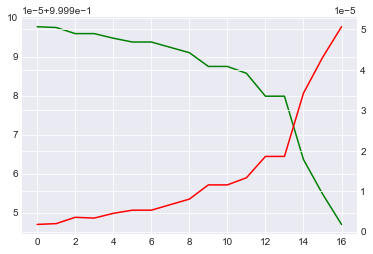

In [13]:
dates, x, sus, inf = get_country_sir('Canada British Columbia', min_cases=10)
# sus and inf are already normalized
# just normalize x
x_train = x[:-3]
x_test = x[-3:]

scalex = MinMaxScaler()
x_scale = scalex.fit_transform(x_train.reshape(-1,1)).flatten()

sus_train = sus[:-3]
sus_test = sus[-3:]

inf_train = inf[:-3]
inf_test = inf[-3:]

# make single array
y_train = np.hstack((sus_train.reshape(-1,1), inf_train.reshape(-1,1)))
y_test = np.hstack((sus_test.reshape(-1,1), inf_test.reshape(-1,1)))

y_train.shape

y0 = y_train[0, :]

fig, ax = plt.subplots()
plt.plot(x_train, y_train[:, 0], c='g', label='suseptible')
#plt.legend()
ax2 = ax.twinx()
ax2.plot(x_train, y_train[:, 1], c='r', label='infected')
#plt.legend()
plt.show()

In [14]:
p0 = [0.1, 0.5, 0.5]  #delta lmbda beta
popt = optimize.least_squares(sir_residual, p0, args = (x_train, y_train, y0))

In [15]:
pnew = popt.x
pnew
pnew

array([0.1      , 0.2535804, 0.414369 ])

In [16]:
pnew[2]/pnew[1]

1.6340734410903577

In [8]:
popt.x

array([0.1      , 0.2535804, 0.414369 ])

In [17]:
pnew = [0, 0.018, 0.12]
#pnew = [delta, lmbda, beta]
#pnew

In [18]:
last = len(x)
num_days = 200
extend = np.arange(last, last+num_days)
x_updated = np.append(x, extend)
y_hat = sir_solution(x_updated, pnew, y0)

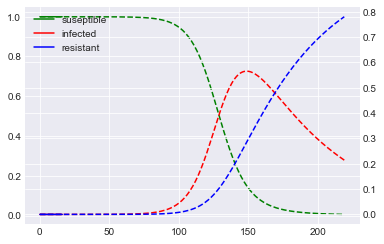

In [19]:
fig, ax = plt.subplots()
plt.plot(x_train, y_train[:, 0], c='g', label='suseptible')
plt.plot(x_updated, y_hat[:, 0], '--g')
handles, labels = ax.get_legend_handles_labels()
#plt.legend()
ax2 = ax.twinx()
ax2.plot(x_train, y_train[:, 1], c='r', label='infected')
ax2.plot(x_updated, y_hat[:,1], '--r')

ax2.plot(x_train, 1-y_train[:,0]-y_train[:, 1], c='b', label='resistant')
ax2.plot(x_updated, 1-y_hat[:,0]-y_hat[:, 1], '--b')
#plt.ylim([0, 1])
#plt.legend()
handles1, labels2 = ax2.get_legend_handles_labels()

plt.legend(handles = handles+handles1, labels=labels+labels2)
plt.show()

In [367]:
# get distribution of best fits using initial conditions?
# draw inits from prior distribution

num_samples = 1000

results_dict = {'delta':[], 'beta': [], 'lmbda': []}
delta_range = np.arange(0, 0.5, 0.05)
lmbda_range = np.arange(1/10, 1/5, 0.05)
beta_range = np.arange(0.5, 1, 0.05)
count = 0
while count < 1000:
    delta_init = halfnorm(loc=0, scale=1).rvs()#np.random.normal(0)
    beta_init = halfnorm(loc=0.5, scale=1).rvs()#np.random.normal(0.5)
    lmbda_init = halfnorm(loc=1/9, scale=1).rvs()#np.random.normal(1/9)
    
    if beta_init > lmbda_init:
        count+=1
    else:
        continue
    
for ii, delta_init in enumerate(delta_range):
    for jj, beta_init in enumerate(beta_range):
        for kk, lmbda_init in enumerate(lmbda_range):

            p0 = [delta_init, lmbda_init, beta_init]

            popt = optimize.least_squares(sir_residual, p0, args = (x_train, y_train, y0))

            pnew = popt.x
            results_dict['beta'].append(pnew[2])
            results_dict['lmbda'].append(pnew[1])
            results_dict['delta'].append(pnew[0])
            
            print_line = '\r delta {:03d}/{:03d} -- beta {:03d}/{:03d} -- lmbda {:03d}/{:03d}'.format(ii+1, 
                                                                                                      len(delta_range),
                                                                                                      jj+1,
                                                                                                      len(beta_range),
                                                                                                      kk+1,
                                                                                                      len(lmbda_range)
                                                                                                      )
            print(print_line, end = '')

 delta 010/010 -- beta 010/010 -- lmbda 002/002

In [331]:
results_df = pd.DataFrame(results_dict)
df = results_df.describe()
delta_mean = df.loc['mean', 'delta']
delta_std = df.loc['std', 'delta']

lmbda_mean = df.loc['mean', 'lmbda']
lmbda_std = df.loc['std', 'lmbda']

beta_mean = df.loc['mean', 'beta']
beta_std = df.loc['std', 'beta']

df

,delta,beta,lmbda
count,200.000000,200.000000,200.000000
mean,0.036034,0.382567,0.035749
std,0.000004,0.000016,0.000002
min,0.036000,0.382419,0.035723
25%,0.036034,0.382568,0.035749
50%,0.036035,0.382570,0.035749
75%,0.036035,0.382571,0.035749
max,0.036038,0.382582,0.035754


In [332]:
results_df.head()

,delta,beta,lmbda
0,0.036034,0.382567,0.035749
1,0.036032,0.382558,0.035749
2,0.036034,0.382566,0.035749
3,0.036035,0.382571,0.035749
4,0.036017,0.382506,0.035751


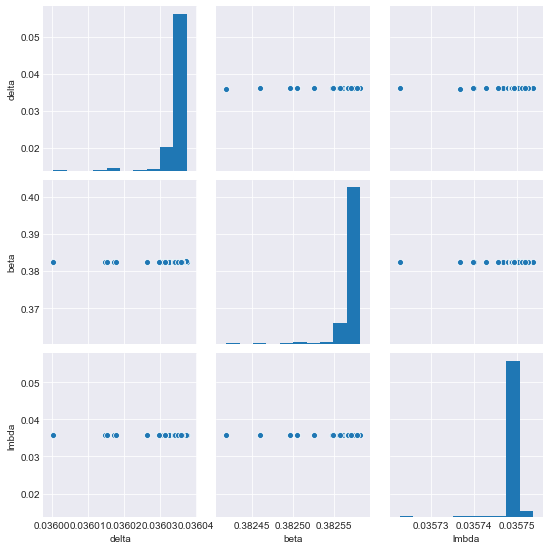

In [333]:
sns.pairplot(results_df)
plt.show()

In [334]:
a = [1,2,3]
np.random.shuffle(a)
a
beta_std

1.6349287826327915e-05

In [335]:
# pull random functions from the options
# get all y values 
num_samples = 100
beta_vals = results_df.beta.values
delta_vals = results_df.delta.values
lmbda_vals = results_df.lmbda.values

indices = np.arange(len(beta_vals))

last = len(x)
num_days = 60
extend = np.arange(last, last+num_days)
x_updated = np.append(x, extend)

y0_array = np.empty((num_samples, len(x_updated)))
y1_array = np.empty((num_samples, len(x_updated)))
y2_array = np.empty((num_samples, len(x_updated)))
for ii in range(num_samples):
    #np.random.shuffle(beta_vals)
    #np.random.shuffle(delta_vals)
    #np.random.shuffle(lmbda_vals)
    
    np.random.shuffle(indices)
    idx = indices[0]
    
    beta = beta_vals[idx]
    delta = delta_vals[idx]
    lmbda = lmbda_vals[idx]
    
    #beta = np.random.normal(beta_mean, beta_std)#beta_vals[0]
    #delta = np.random.normal(delta_mean, delta_std)#delta_vals[0]
    #lmbda = np.random.normal(lmbda_mean, lmbda_std)#lmbda_vals[0]
    
    y_hat = sir_solution(x_updated, [delta, lmbda, beta], y0)
    
    y0_array[ii, :] = y_hat[:, 0]
    y1_array[ii, :] = y_hat[:, 1]
    y2_array[ii, :] = 1 - y_hat[:, 0] - y_hat[:, 1]

In [337]:
y0_mean = np.mean(y0_array, axis=0)
y0_std = 2*np.std(y0_array, axis=0)

y1_mean = np.mean(y1_array, axis=0)
y1_std = 2*np.std(y1_array, axis=0)

y2_mean = np.mean(y2_array, axis=0)
y2_std = 2*np.std(y2_array, axis=0)

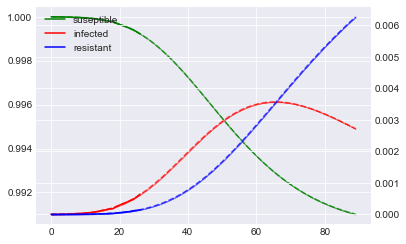

In [338]:
fig, ax = plt.subplots()
plt.fill_between(x_updated, y0_mean+y0_std, y0_mean-y0_std, alpha=0.5, color='g')
plt.plot(x_train, y_train[:, 0], c='g', label='suseptible')
plt.plot(x_updated, y0_mean, '--g', alpha=0.7)
handles, labels = ax.get_legend_handles_labels()
#plt.legend()
ax2 = ax.twinx()

plt.fill_between(x_updated, y1_mean+y1_std, y1_mean-y1_std, alpha=0.5, color='r')
ax2.plot(x_train, y_train[:, 1], c='r', label='infected')
ax2.plot(x_updated, y_hat[:,1], '--r', alpha=0.7)


plt.fill_between(x_updated, y2_mean+y2_std, y2_mean-y2_std, alpha=0.5, color='b')
ax2.plot(x_train, 1-y_train[:,0]-y_train[:, 1], c='b', label='resistant')
ax2.plot(x_updated, 1-y_hat[:,0]-y_hat[:, 1], '--b', alpha=0.7)
#plt.legend()
handles1, labels2 = ax2.get_legend_handles_labels()

plt.legend(handles = handles+handles1, labels=labels+labels2)
plt.show()